
# Clouds Step By Step

Reconstruct and event with clouds, step by step.

Didactic and debugin purposes.

#### JA Hernando, April 2021

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import matplotlib.pyplot as plt

import clouds.clouds    as clouds
import clouds.pltclouds as pltclouds

import clouds.ridges    as ridges

In [3]:
plt.rcParams['image.cmap'] = 'Blues'

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Sat May 15 10:45:32 2021


## Generate an event


Generate points along a line with a given dispersion in (x, y)

## Generate sample

In [4]:
def canvas(nx = 1, ny = 1, xsize = 4., ysize = 5):
    plt.figure(figsize = (ny * ysize, nx * xsize))
    subplot = lambda i : plt.subplot(nx, ny, i)
    return subplot

In [5]:
def generate_points(sizes, line = None, sigma = 1):
    
    size0   = np.min(sizes)
    npoints = len(sizes)
    ts = np.linspace(0, 1., npoints)
    ts = [ni * [ti,] for ni, ti in zip(sizes, ts)]
    ts.append(np.random.uniform(size = size0))
    ts = np.concatenate(ts)

    size = len(ts)
    iden = lambda x: x
    x, y = (iden, iden) if line is None else line
    xs   = x(ts) + sigma * np.random.normal(size = size)
    ys   = y(ts) + sigma * np.random.normal(size = size)
    
    return xs, ys

In [6]:
sizes = 1000 * np.array((3, 2, 2, 2, 2, 3))
scale, offset = 5, 2
line  = lambda x: scale * x,  lambda x: offset + scale * x
xs, ys = generate_points(sizes, line, sigma = 0.6)

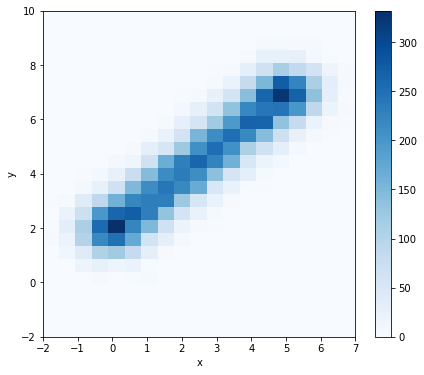

In [7]:
size  = 2
xbins = np.linspace(-2,  7, size * 10)
ybins = np.linspace(-2, 10, size * 13)

bins          = (xbins, ybins)
counts, _, _  = np.histogram2d(xs, ys, bins = bins)

subplot = canvas(1, 1, 6, 7)
subplot(1)
plt.hist2d(xs, ys, bins);
#plt.imshow(counts.T, origin = 'lower')
plt.xlabel('x'); plt.ylabel('y')
plt.colorbar();

## Clouds input

   * Input data are:
       
       * coors   : a list of coordinates of the points: (x, y)
       
       * steps   : a list with the steps in each dimention (x-step, y-step)
       
       * weights : the weigths or energy of each point (ene)

In [8]:
coors   = (xs, ys)
steps   = (xbins[1] - xbins[0], ybins[1] - ybins[0])
print('steps ', steps)
weights = np.ones(len(xs))

steps  (0.4736842105263157, 0.48)


## 1 Clouds - Nodes

   1. Construct the 'energy' histogram in voxels with step size
   
   2. Select the cells with energy above a given threshold (default 0.) 
   
   3. Asign an ID to each cell
      
   4. Compute the magnitude of the gradient in each cell.
   
   5. Compute the gradient to the next neighbour for each cell
   
   6. Compute the nodes, the cells with no gradient to other neighbours.
   
   7. Compute the node to which each cell belongs. 
   

### Potential and cells IDs

   * *bins*  : is a list with the bin-edges in each dimension
   
   * *mask*  : a ndim-array with the True/False position of each cell
   
   * *icells*: is a list of the i-positions in each dimension
   
   * *cells* : is a list with the positions in each dimension 
   
   * *ene*   : is the potential/energy of each cell
   
   * *kid*   : is an ID, an int, for each cell

In [9]:
bins, mask, icells, cells, enes = clouds.frame(coors, steps, weights)

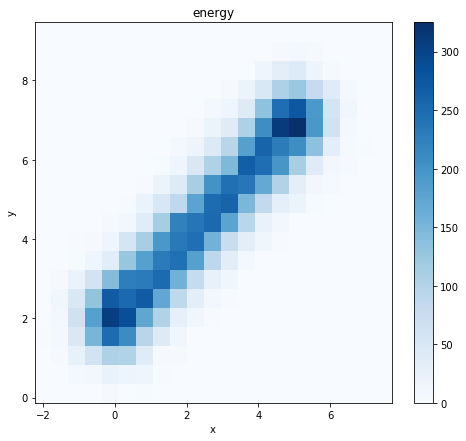

In [10]:
canvas(1, 1, 7, 8)

plt.hist2d(*cells, bins = bins, weights = enes)
plt.xlabel('x'); plt.ylabel('y'); plt.title('energy')
plt.colorbar();


### Compute gradient 

   * *egrad*: is the delta potential to the neighbout cell with the largest potential
   
   * *epath*: is the ID of the neighbour cell with the largest potential

In [11]:
egrad, epath = clouds.gradient(bins, mask, cells, enes)

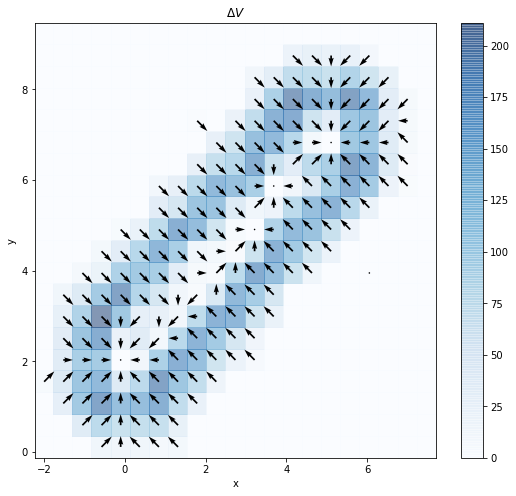

In [12]:
canvas(1, 1, 8, 9)
plt.hist2d(*cells, bins = bins, weights = egrad, alpha = 0.5)
plt.colorbar();
pltclouds.draw_grad(cells, epath)
plt.xlabel('x'); plt.ylabel('y'); plt.title(r'$\Delta V$');
#plt.plot((0, 5), (2, 7), color = 'red',ls = '--');

### Compute the nodes

   * *isnode*: True/False if this cell is a node
   
   * *node*: the ID of the cells that is the node to wich each cells belongs
   

In [13]:
isnode = clouds.find_nodes(egrad)
node   = clouds.set_node(epath)
cells_selection = clouds.cells_selection

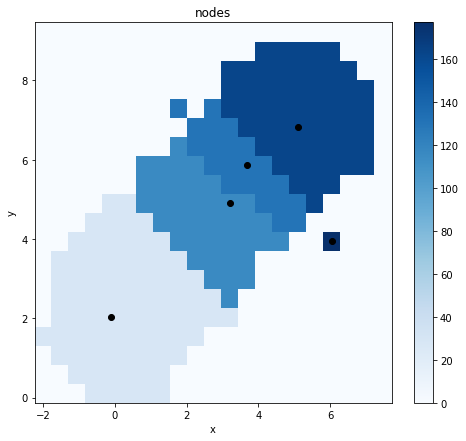

In [14]:
canvas(1, 1, 7, 8)

plt.hist2d(*cells, bins = bins, weights = node)
plt.colorbar();
plt.plot(*cells_selection(cells, isnode), marker = 'o', ls = '', color = 'black');
plt.xlabel('x'); plt.ylabel('y'); plt.title('nodes');

### Path of each cell to its node

  One can reach the node from any cell via two helper functions:
  
  *get_path*    : returns the list of the cells from a given one to the node,
  *get_segment* : converts the list of cells-IDs into a cartesian segment

In [15]:
kid     = 10
path    = clouds.get_path(kid, epath)
segment = clouds.get_segment(cells, path) 

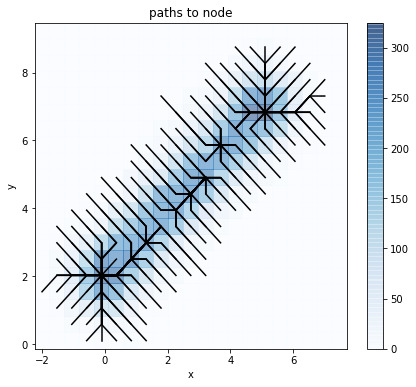

In [16]:
subplot = canvas(1, 1, 6, 7)

size    = len(cells[0])
kids    = np.arange(size)
subplot(1)
plt.hist2d(*cells, bins = bins, weights = enes, alpha = 0.5)
paths     = [clouds.get_path(kid, epath)      for kid in kids]
segments  = [clouds.get_segment(cells, path) for path in paths]
for segment in segments:
    plt.plot(*segment, c = 'black');
plt.xlabel('x'); plt.ylabel('y'); plt.title('paths to node')
plt.colorbar();

## 2. Passes

   * Define the divergent region
   
   * Calculate the borders between nodes
   
   * Calculate the gradiant of the border cells to the other node
   
   * Select the pass with the highest pass in the divergent region.


### Define the convex region

  * Compute the laplacian and select the region with negative laplacian (dispersive region)

In [17]:
#cells_selection_ = pltclouds.cell_selection
laplacian   = clouds.laplacian(bins, mask, cells, enes)
cutoff      = np.percentile(laplacian, 25.)
cutoff      = min(0., cutoff)
print(cutoff)
isdivergent = laplacian < cutoff

-93.57079475308643


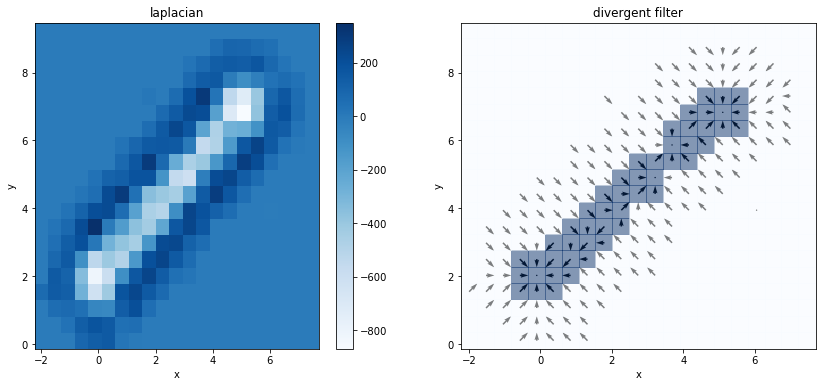

In [18]:
subplot = canvas(1, 2, 6, 7)
subplot(1)
plt.hist2d(*cells, bins = bins, weights = laplacian)
plt.xlabel('x'); plt.ylabel('y'); plt.title('laplacian')
plt.colorbar();

subplot(2)
pltclouds.draw_grad(cells, epath);
plt.hist2d(*cells, bins, weights = isdivergent, alpha = 0.5)
plt.xlabel('x'); plt.ylabel('y'); plt.title('divergent filter');

### Identify the cells in the border 

   * *lgrand*: The potential of this cell plus the potencial on the neighbour cell of the connected node with the largest potential 
   
   * *lnode*: The ID of the connected node of the other region to which this cell is a border cell
   
   * *lpath*: The ID of the neighbour cell with the largest potential on the connected region.

In [19]:
isborder, idborder  = clouds.find_borders(bins, mask, cells, node)

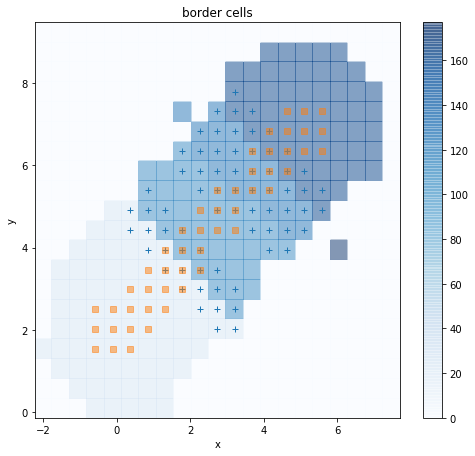

In [20]:
subplot = canvas(2, 2, 8, 9)

subplot(1)
plt.hist2d(*cells, bins, weights = node  , alpha = 0.5);
plt.colorbar();
plt.plot(*cells_selection(cells, isborder)   , marker = '+', ls = '');
#plt.plot(*cells_selection(cells, idborder == -1)   , marker = 'x', ls = '', c ='black');
plt.plot(*cells_selection(cells, isdivergent), marker = 's', ls = '', alpha = 0.5);
plt.xlabel('x'); plt.ylabel('y'); plt.title('border cells');

In [21]:
lgrad, lpath = clouds.gradient_between_nodes(bins, mask, cells, enes, node, isborder,
                                             absolute = True)

Text(0.5, 1.0, 'links')

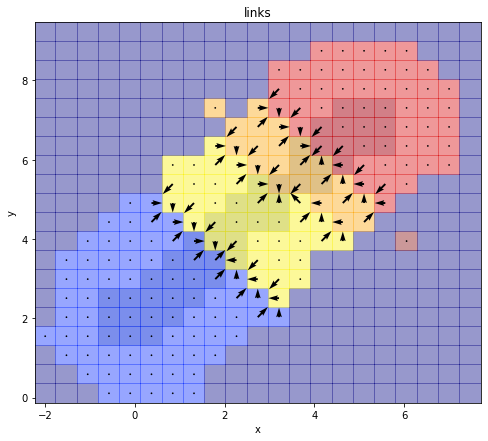

In [22]:
canvas(1, 1, 7, 8)
plt.hist2d(*cells, bins, weights = isdivergent, alpha = 0.2);
plt.hist2d(*cells, bins, weights = node       , alpha = 0.4, cmap = 'jet');
pltclouds.draw_grad(cells, lpath)
#plt.hist2d(*cells, bins, weights = lgrad      , alpha = 0.4);
#plt.hist2d(*csel_(cells, cells_border), bins, weights = cells_lpath[cells_border]);
plt.xlabel('x'); plt.ylabel('y'); plt.title(r'links')

## 3. Selecting the passes

   * Select a pass:
   
      * cells with oposite gradient in the borders
  
      * cells in oposite node regions
      
      * dispersive cells (negative laplacian)
  

In [23]:
ispass = clouds.find_passes(node, lpath, lgrad, isdivergent)
print('number of cells passes', int(np.sum(ispass)/2))

number of cells passes 3


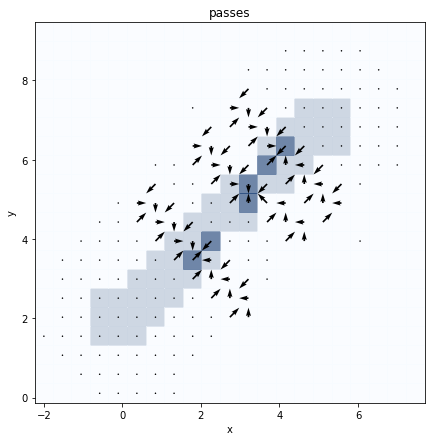

In [24]:
canvas(1, 1, 7, 7)
#plt.hist2d(*cells, bins, weights = isborder  , alpha = 0.3);
plt.hist2d(*cells, bins, weights = isdivergent, alpha = 0.3)
plt.hist2d(*cells, bins, weights = ispass     , alpha = 0.4)
pltclouds.draw_grad(cells, lpath)
plt.xlabel('x'); plt.ylabel('y'); plt.title(r'passes');

## Ridges

In [25]:
ridges   = clouds.get_new_ridges(ispass, epath, lpath)
isridge  = clouds.find_new_ridge (ispass, epath, lpath)
eridge   = clouds.energy_in_ridge(enes, isridge, epath)

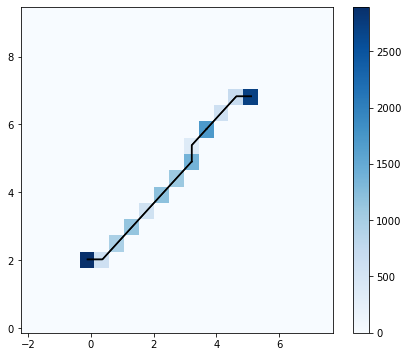

In [26]:
canvas(1, 1, 6, 7)

plt.hist2d(*cells, bins, weights = eridge, alpha = 1.)
plt.colorbar();
for path in ridges:
    segment = clouds.get_segment(cells, path)
    plt.plot(*segment, ls = '-', c = 'black' )

In [27]:
print('ridge energy ', np.sum(eridge), 'total energy', np.sum(enes))

ridge energy  15999.0 total energy 16000.0


## Ridge

In [28]:
## Ridges
plt.rcParams['image.cmap'] = 'rainbow'
cells_select = clouds.cells_select
import clouds.ridges as ridges
import clouds.pltridges as pltridges

In [29]:
img, _  = np.histogramdd(cells, bins, weights = enes)
steps   = [bin[1] - bin[0] for bin in bins]
vgrad, ridge, sel_ridge, lap, l1 = ridges.ana(img, steps)
print(vgrad.shape)

(21, 20)


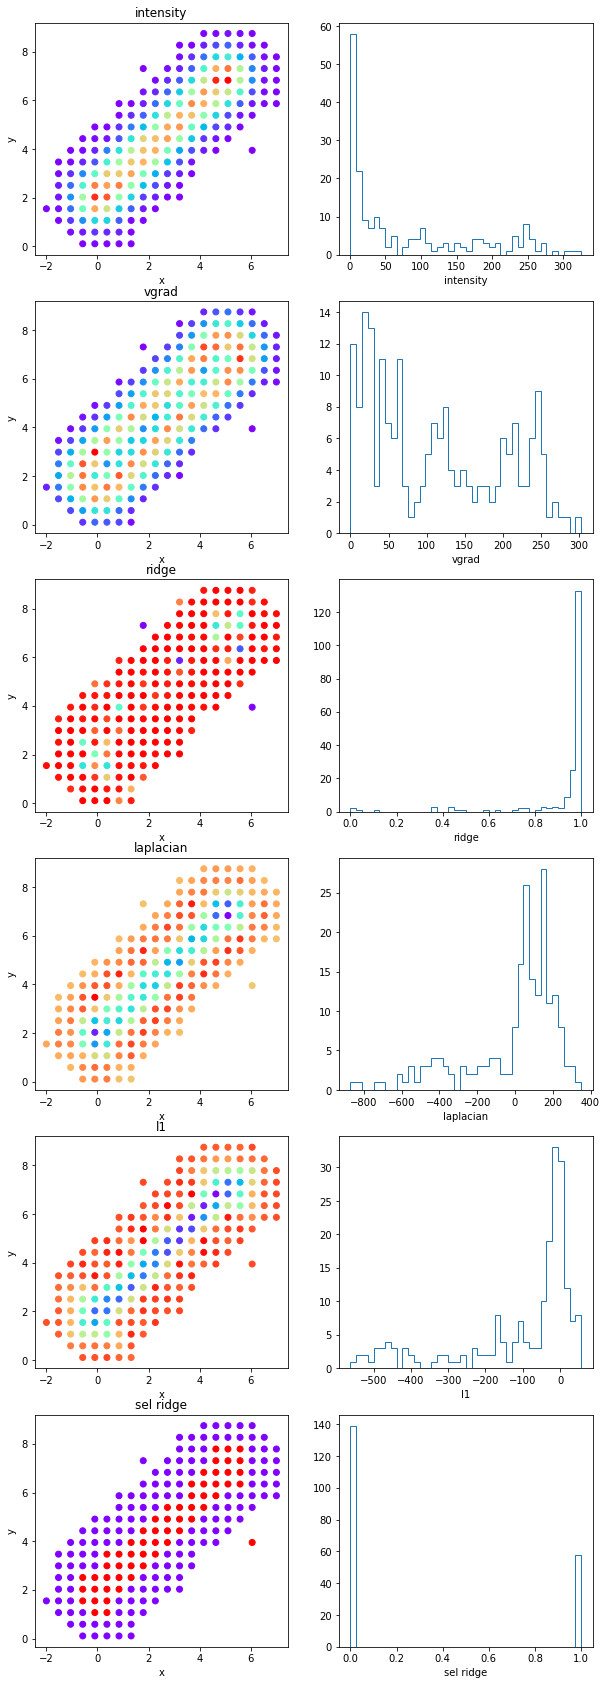

In [30]:
plot = pltridges.plotter(bins, mask, cells)
nplots = 7
fig = plt.figure(figsize = (10, 5 * nplots))
uvars = ((img, 'intensity'), (vgrad, 'vgrad'), (ridge, 'ridge'),
         (lap, 'laplacian'), (l1, 'l1'), (sel_ridge.astype(float), 'sel ridge'))
for i, uvar in enumerate(uvars):
    plot(*uvar, n = nplots, i = 2*i + 1, alpha = 1.)

### Select percentile

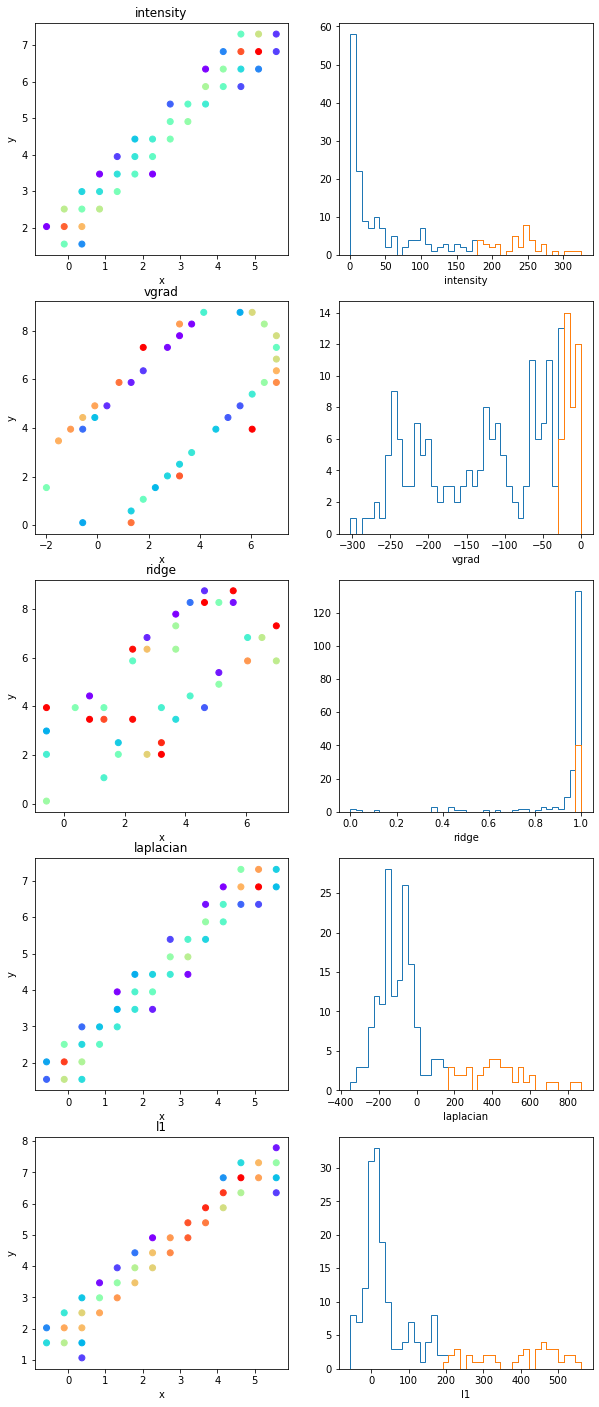

In [31]:
nplots = 7
fig = plt.figure(figsize = (10, 5 * nplots))
uvars = ((img, 'intensity'), (-vgrad, 'vgrad'), (ridge, 'ridge'),
         (-lap, 'laplacian'), (-l1, 'l1'))
for i, uvar in enumerate(uvars):
    plot(*uvar, perc = 80, n = nplots, i = 2*i + 1, alpha = 1.)